# Dog Breed Classification Using Deep Learning in AWS Sagemaker


The goal of this project is to demonstrate how we can use a pretrained image classification model to classify the dog breed given an image of the dog. This is done by loading the pretrained model then using transfer learning we adapt the model to the dog breed classification dataset.


In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [3]:
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
print(f'Execition Role: {role}')
print(f'Default s3 bucket : {bucket}')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
[2024-08-02 08:58:26.537 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:101 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
Execition Role: arn:aws:iam::745861608821:role/service-role/AmazonSageMaker-ExecutionRole-20240728T142291
Default s3 bucket : sagemaker-us-east-1-745861608821


## Dataset

The Dataset Contains images of dogs of different breeds.
There are 133 classes of dog breeds available.
The Dataset is split into three directories train, validation and testing.
Each Directory has 133 sub directories, one directory per dog breed class.

In [4]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2024-08-02 09:03:28--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.193.112, 52.219.116.88, 52.219.220.200, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.193.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  18.1MB/s    in 38s     

2024-08-02 09:04:07 (28.4 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jp

In [5]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix='imagesDogClassesSet')
print(f'Input path (S3 file path): {inputs}')

Input path (S3 file path): s3://sagemaker-us-east-1-745861608821/imagesDogClassesSet


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
#TODO: Declare your HP ranges, metrics etc.

In [6]:
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([16 ,32, 64]),
    'epochs': IntegerParameter(2, 6)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


In [7]:
estimator = PyTorch(entry_point = 'hpo.py',
                                    base_job_name = 'dog-breed-classification-hpo',
                                    role = role,
                                    instance_count = 1,
                                    instance_type = 'ml.m5.2xlarge', 
                                    py_version = 'py36',
                                    framework_version = '1.8')

tuner = HyperparameterTuner(estimator,
                                                     objective_metric_name,
                                                     hyperparameter_ranges,
                                                     metric_definitions,
                                                     max_jobs = 4,
                                                     max_parallel_jobs = 1,
                                                     objective_type = objective_type)

In [8]:
tuner.fit({'train': inputs}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................................................................................................................!


In [9]:
best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()


2024-08-02 09:41:20 Starting - Found matching resource for reuse
2024-08-02 09:41:20 Downloading - Downloading the training image
2024-08-02 09:41:20 Training - Training image download completed. Training in progress.
2024-08-02 09:41:20 Uploading - Uploading generated training model
2024-08-02 09:41:20 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"32"',
 'epochs': '6',
 'lr': '0.00633732645759613',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2024-08-02-09-24-47-854"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-745861608821/dog-breed-classification-hpo-2024-08-02-09-24-47-854/source/sourcedir.tar.gz"'}

In [10]:
best_hyperparameters = {'batch_size': 64,
                                          'epochs': 2,
                                          'lr': 0.004030880500753202}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [11]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, 
                                                       framework_profile_params = FrameworkProfile(num_steps=10))

collection_config = [CollectionConfig(name="CrossEntropyLoss_output_0", 
                                    parameters={"include_regex": "CrossEntropyLoss_output_0",
                                                            "train.save_interval": "10",
                                                            "eval.save_interval": "1"})]

debugger_config = DebuggerHookConfig(collection_configs = collection_config)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [12]:
estimator = PyTorch(entry_point = 'train_model.py',
                                    role = role,
                                    instance_count=1,
                                    instance_type = 'ml.m5.2xlarge',
                                    py_version = 'py36',
                                    framework_version = '1.6',
                                    hyperparameters = best_hyperparameters,
                                    profiler_config = profiler_config, 
                                    debugger_hook_config = debugger_config, 
                                    rules = rules ) 

In [13]:
estimator.fit({'train':inputs}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-08-02-09-46-42-517


2024-08-02 09:46:43 Starting - Starting the training job...
2024-08-02 09:47:09 Starting - Preparing the instances for trainingVanishingGradient: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-08-02 09:47:29 Downloading - Downloading input data...
2024-08-02 09:48:12 Downloading - Downloading the training image...
2024-08-02 09:48:29 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-02 09:48:39,860 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-02 09:48:39,862 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-08-02 09:48:39,873 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-02 09:48:39,875 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-08-02 

In [14]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2024-08-02-09-46-42-517
Client: <botocore.client.SageMaker object at 0x7f49fea8dd80>
Description: {'TrainingJobName': 'pytorch-training-2024-08-02-09-46-42-517', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:745861608821:training-job/pytorch-training-2024-08-02-09-46-42-517', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-517/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '64', 'epochs': '2', 'lr': '0.004030880500753202', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2024-08-02-09-46-42-517"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-517/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazo

In [ ]:
# TODO: Plot a debugging output.

In [15]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-08-02 10:32:27.914 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:101 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-517/debug-output


In [16]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    print(f"[INFO] Getting data in {len(steps)} steps")
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
        print(".", end="")
    return steps, vals

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(20, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

INFO:matplotlib.font_manager:generated new fontManager


[2024-08-02 10:32:42.735 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:101 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-08-02 10:32:43.762 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:101 INFO trial.py:210] Loaded all steps
[INFO] Getting data in 21 steps
.....................loaded TRAIN data
[INFO] Getting data in 42 steps
..........................................loaded EVAL data
completed TRAIN plot
completed EVAL plot


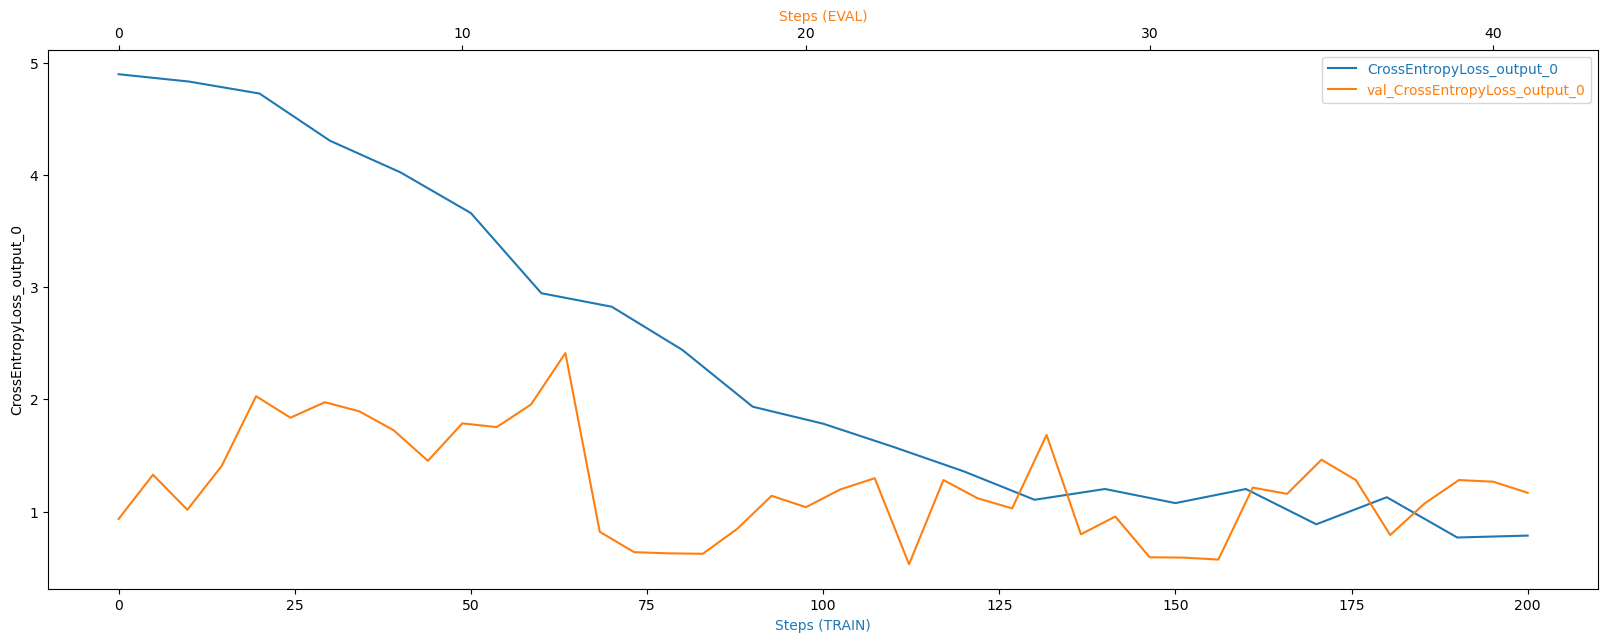

In [18]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [19]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print('Profiler report location: {}'.format(rule_output_path))

Profiler report location: s3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-517/rule-output


In [20]:
! aws s3 ls {rule_output_path} --recursive

2024-08-02 10:31:24     375840 pytorch-training-2024-08-02-09-46-42-517/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-08-02 10:31:23     223798 pytorch-training-2024-08-02-09-46-42-517/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-08-02 10:31:18        192 pytorch-training-2024-08-02-09-46-42-517/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-08-02 10:31:18        200 pytorch-training-2024-08-02-09-46-42-517/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-08-02 10:31:18       1948 pytorch-training-2024-08-02-09-46-42-517/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-08-02 10:31:18        127 pytorch-training-2024-08-02-09-46-42-517/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-08-02 10:31:18        199 pytorch-training-2024-08-02-09-46-42-517/rule-output/ProfilerReport/profiler-output/profiler-re

In [21]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-517/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-517/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-517/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-517/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-5

In [22]:
import os

profiler_report_name = [ rule["RuleConfigurationName"]
                                            for rule in estimator.latest_training_job.rule_job_summary()
                                            if "Profiler" in rule["RuleConfigurationName"]
                                            ][0]

In [23]:
import IPython

IPython.display.HTML(filename= profiler_report_name + "/profiler-output/profiler-report.html")

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [24]:
model_location = estimator.model_data
model_location

's3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-517/output/model.tar.gz'

In [25]:
model_location

's3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-517/output/model.tar.gz'

In [26]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel(model_data = model_location,
                             role = role,
                             entry_point= "deploy_endpoint.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.2xlarge")

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-745861608821/pytorch-training-2024-08-02-09-46-42-517/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-745861608821/pytorch-inference-2024-08-02-10-38-14-052/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-08-02-10-38-23-778
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-08-02-10-38-24-570
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-08-02-10-38-24-570


-------!

Display Image:


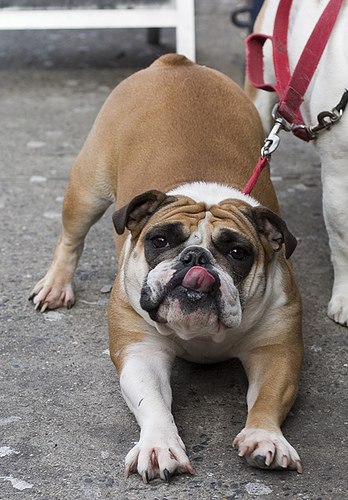

Expected Class: 40
Inference on class: [69] 


Display Image:


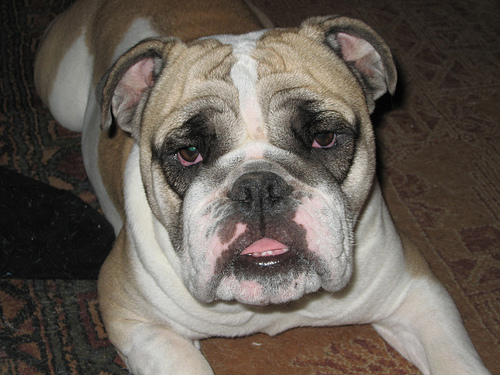

Expected Class: 40
Inference on class: [41] 


Display Image:


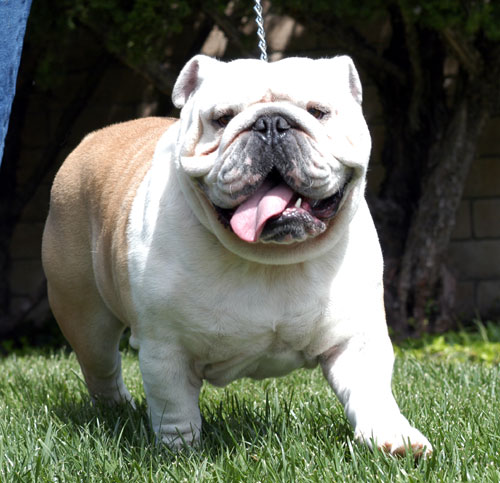

Expected Class: 40
Inference on class: [40] 


Display Image:


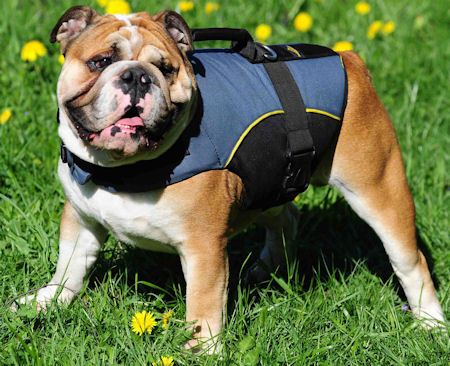

Expected Class: 40
Inference on class: [69] 


Display Image:


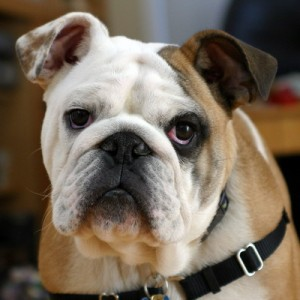

Expected Class: 40
Inference on class: [41] 


Display Image:


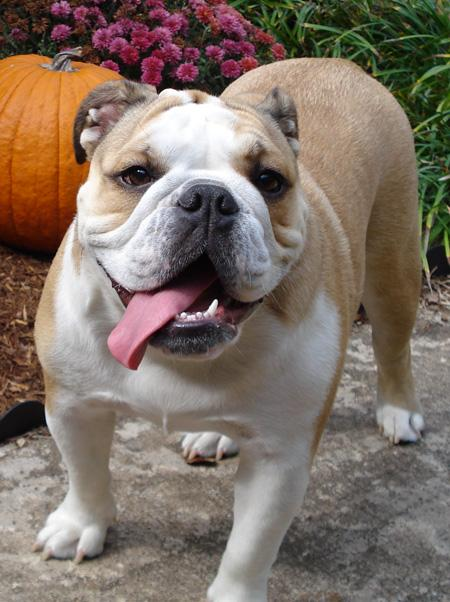

Expected Class: 40
Inference on class: [40] 


Display Image:


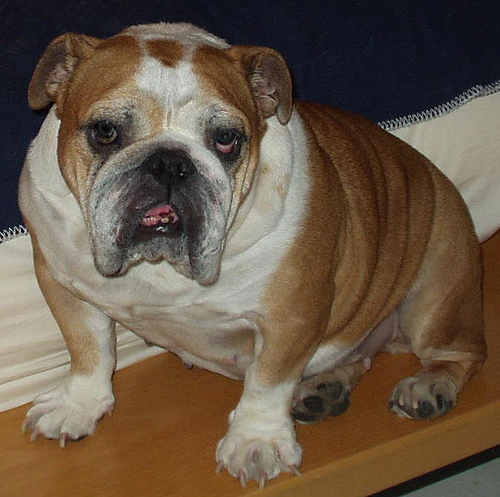

Expected Class: 40
Inference on class: [40] 




In [30]:
from PIL import Image
import io
import os
import numpy as np

test_dir = "./dogImages/test/040.Bulldog/"
test_images = ["Bulldog_02817.jpg", "Bulldog_02828.jpg", "Bulldog_02834.jpg", "Bulldog_02835.jpg", 
                           "Bulldog_02842.jpg", "Bulldog_02845.jpg", "Bulldog_02846.jpg"]
test_images_expected_output = 40

for index in range(len(test_images)):
    
    test_image = test_images[index]
    test_file_path = os.path.join(test_dir, test_image) 
    
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Display Image:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected Class: {test_images_expected_output}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"}) 
        predicted_dog_breed = np.argmax(response, 1) + 1
        print(f"Inference on class: {predicted_dog_breed} \n\n")

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()